----
# Tutorial for Evaluating Fairness in Binary Classification

----
## Evaluating Your Own Model? Looking for a Template? 
**Please note: This notebook is intended as an introduction to and reference for evaluating the fairness of a set of machine learning models using FairMLHealth, and it is not designed to work with outside models.**  

We recommend using our [Template-BinaryClassificationAssessment](../templates/Template-BinaryClassificationAssessment.ipynb) if you are looking for a template into which you can insert existing models. 


## Overview

This notebook introduces concepts, methods, and libraries for measuring fairness in machine learning (ML) models as it relates to problems in healthcare. This is a revised version of the tutorial presented at the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](../docs/publications/KDD2020-FairnessInHealthcareML-Slides.pdf), the notebook for which can be found here: [/docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb](../docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb).

[Part 1](#part1) will frame the problem and introduce our hypothetical example predicting Length of Stay (LOS) based on a subset of the [MIMIC-III clinical database](https://mimic.physionet.org/gettingstarted/access/). In [Part 2](#part2) this baseline model is used as an example to evaluate and discuss common metrics like *Disparate Impact*, *Equalized Odds*, and *Consistency Scores*. Then, [Part 4] compares the results of the baseline model to results for other modeling approaches: one "unaware" version, a "fairness-aware" version, and a third version simply using a different standard machine learning algorithm. 

There are abundant other publications covering the theoretical basis for fairness metrics, with many online and academic resources covering the details of specific fairness measures (See [References (bottom)](#references) and [Additional Resources (bottom)](#additional_resources), or [Our Resources Page](../docs/resources/Measures_QuickReference.md)). Many of these excellent references fall short of discussing edge cases as well as the practical and philosophical considerations when evaluating real models for real customers. Here we attempt to bridge this gap.



## Table of Contents
[Part 1](#part1) - Framing the Problem
  
[Part 2](#part2) - Evaluating the Baseline Model

[Part 3](#part3) - Comparing Models 
  
[References](#references)
  


## Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth#installation_instructions). Some components of this notebook additionally require the [Fairlearn](https://github.com/fairlearn/fairlearn) package.

The tutorial uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location, and you do not need to unzip any files.

A basic knowledge of ML implementation in Python is assumed. 


----
---- 
# Part 1 - Framing the Problem <a class = "anchor" id = "part1"></a>

## Background
In issues of social justice, discrimination is the unjustified, differential treatment of individuals based on their sociodemographic status [[Romei and Ruggieri 2014]](#romei2014_ref).  A "fair" model is one that does not discriminate. Therefore, the goal of our work is to evaluate (a) whether our model makes similar predictions for all socially salient groups, or (b) whether any differences arise that are ethically justified.

For more in-depth background information, see the [Evaluating Fairness Reference](../docs/resources/Evaluating_Fairness.md) and the [Measures Quick Reference](../docs/resources/Measures_QuickReference.md) in our documentation. A reference table with basic definitions is provided below.

### Fairness Definitions  <a id="metric_quickref"></a>

Three  metric categories are commonly used for determining whether a model is considered "fair": (1) Group Fairness, which compares the statistical similarities of predictions relative to known and discrete protected groupings; (2) Similarity-Based Measures, which evaluate predictions without those discrete protected groups; and (3) Causal Reasoning measures, which evaluate fairness through the use of causal models.

| Category | Metric | Definition | Weakness | References |
|------|------|------|------|------|
| Group Fairness |**Demographic Parity**| A model has **Demographic Parity** if the predicted positive rates (selection rates) are approximately the same for all protected attribute groups: $\dfrac{P(\hat{y} = 1 \lvert unprivileged)}{P(\hat{y} = 1 \rvert privileged)}$ <br> <br> Harms Addressed: Allocative| Historical biases present in the data are not addressed and may still bias the model. | [Zafar *et al* (2017)](#zafar2017_ref) |
||**Equalized Odds**| Odds are equalized if $P(+)$ is approximately the same for all protected attribute groups.<br>  **Equal Opportunity** is a special case of equalized odds specifying that $P(+ \rvert y = 1)$ is approximately the same across groups. <br> <br> Harms Addressed: Allocative, Representational | Historical biases present in the data  are not addressed and may still bias the model. | [Hardt *et al* (2016)](#hardt2016_ref) |
||**Predictive Parity**| This parity exists where the Positive Predictive Value is approximately the same for all protected attribute groups. <br> <br> Harms Addressed: Allocative, Representational | Historical biases present in the data are not addressed and may still bias the model.  | [Zafar *et al* (2017)](#zafar2017_ref) |
||||||
| Similarity-Based Measures |**Individual Fairness**| Individual fairness exists if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions. <br> <br> Harms Addressed: Representational | The appropriate metric for similarity may be ambiguous. |[Dwork (2012)](#dwork2012_ref), [Zemel (2013)](#zemel2013_ref), [Kim *et al* (2018)](#kim2018_ref) |
| &nbsp; |**Entropy-Based Indices**| Measures of entropy, particularly existing inequality indices from the field of economics, are applied to evaluate either individuals or groups <br> <br> Harms Addressed: Representational |  |[Speicher (2018)](#speicher2018_ref) |
| &nbsp; |**Unawareness** | A model is unaware if the protected attribute is not used. <br> <br> Harms Addressed: Allocative, Representational | Removal of a protected attribute may be ineffectual due to the presence of proxy features highly correlated with the protected attribute.| [Zemel *et al* (2013)](#zemel2013_ref), [Barocas and Selbst (2016)](#barocas2016_ref) |
||||||
| Causal Reasoning |**Counterfactual Fairness** \*| Counterfactual fairness exists where counterfactual replacement of the protected attribute does not significantly alter predictive performance. This counterfactual change must be propogated to correlated variables. <br><br>Harms Addressed: Allocative, Representational | It may be intractable to develop a counterfactual model.  | [Russell *et al* (2017)](#russell2017_ref) |
||||||

\* *Note that this tutorial will not elaborate the details of Counterfactual Fairness since the libraries used do not have built-in functionality for it. For an example of Counterfactual Fairness, see "ThemisML" by [Bantilan (2018)](#bantilan2018_ref).*


## Problem Definition
Let's examine a model built for a hypothetical program providing early health and financial counseling to patients expected to experience a prolonged length of stay (LOS) in an intensive care unit (ICU) ward. The service is paid for by small donations from the community it serves. We have found that LOS for this program can be predicted with reasonable performance, and as contemporaries in the healthcare industry, we would like to ensure that resources are distributed among our patients fairly. 

Our baseline model will use the patient's age, diagnosis, language, and the use of medical procedures during their stay to predict this value. Our model produces a binary prediction indicating whether or not the LOS for a given admission is greater than the mean. Observations have been dropped where LOS values are extremely large (30 days or greater) or negative (indicating that the patient was deceased upon arrival at the ICU).


In [1]:
# Verify that all required packages are present
from fairmlhealth.__validation import validate_tutorial_requirements
validate_tutorial_requirements()

# fairMLHealth tools
from fairmlhealth import measure, report, stat_utils

# Loaders specific to fairMLHealth tutorials
from fairmlhealth.__mimic_data import load_mimic3_example, feature_table

In [2]:
# Standard Libraries
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import sys
import warnings

# AIF360 Measures
import aif360.sklearn.metrics as aif_skmetrics

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed

### Loading the MIMIC III Data Subset <a id="datasubset"></a>

As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as Boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
# Load data and keep a 10K observation subset to speed processing
df = load_mimic3_example(path_to_mimic_data_folder) 
df = df.sample(n=10000, random_state=365).reset_index(drop=True)

# Subset to ages 65+
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis=1, inplace=True) # Redundant with GENDER_M

# Display insights
display(feature_table(df))
print("\n\n", "Below is a scrollable version of the first five rows of data:")
display(df.head())


 This data subset has 4818 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features).
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20




 Below is a scrollable version of the first five rows of data:


,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

### Generating the Model <a id="generatemodel"></a>


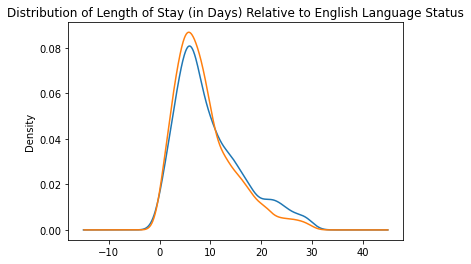

In [5]:
# Display LOS Distributions
ax = df.groupby('LANGUAGE_ENGL')['length_of_stay'
        ].plot(kind='kde', 
               title="Distribution of Length of Stay (in Days) Relative to English Language Status")
plt.show()

In [6]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val = df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)

In [7]:
# Subset data
baseline_cols = [c for c in df.columns if (c.startswith('AGE') or c.startswith('DIAGNOSIS_') or c.startswith('PROCEDURE_') or c == "LANGUAGE_ENGL")]
X = df.loc[:,baseline_cols]
y = df['long_los']

# Split data into test and train
splits = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = splits

# Set model parameters (determined via grid search elsewhere)
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 
              'learning_rate': 0.05, 'max_depth': 5, 
              'min_child_weight': 1, 'n_estimators': 600, 
              'subsample': 0.6, 'eval_metric':'logloss',
              'use_label_encoder':False}

rf_params = {'n_estimators': 1800, 'min_samples_split': 5, 'bootstrap': False}

In [8]:
# Train New Model with Language Feature
baseline_model = XGBClassifier(**xgb_params)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

### FairMLHealth Stratified Data Table

FairMLHealth includes stratified table features to aid in identifying the source of unfairness or other bias. The data table can be used to compare basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since many features can be evaluated at once, it can be a useful option for identifying patterns of bias either alone or in concert with other methods (e.g., visualization).

Our experiment tests sociodemographic bias as it relates to language. Language may also be used as a proxy for race, religion, or nationality, which are [explicitly protected attributes](https://www.eeoc.gov/employers/small-business/3-who-protected-employment-discrimination). 

In this example we can see that there are similar sample sizes (within 6%) for the English speaking and Non-English speaking groups, where Non-English speakers are more likely to have a prolonged length of stay. 

In [9]:
print("FairMLHealth Stratified Table")
measure.data(X_test, y_test, features=['LANGUAGE_ENGL'])

FairMLHealth Stratified Table


,Feature Name,Feature Value,Obs.,Entropy,Mean long_los,Median long_los,Missing Values,Std. Dev. long_los,Value Prevalence
0,ALL FEATURES,ALL VALUES,1590,NaN,0.3887,0.0,0,0.4876,1.0000
1,LANGUAGE_ENGL,0,713,0.9923,0.4250,0.0,0,0.4947,0.4484
2,LANGUAGE_ENGL,1,877,0.9923,0.3592,0.0,0,0.4800,0.5516


### Significance Testing

It is generally recommended to test whether any differences in model outcomes for protected attributes are the effect of a sampling error in our test. FairMLHealth comes with a bootstrapping utility and supporting functions that can be used in statistical testing. The bootstrapping feature accepts any function that returns a p-value and will return a True or False if the p-value is greater than some alpha for a threshold number of randomly sampled trials. Eamples using the bootstrap_significance tool with built-in test functions are shown below. The first test indicates that there is likely a statistically significant difference in the mean of length of stay between English speakers and Non-English speakers. However, per the second and third tests there is not evidence of a statistically significant difference in the distribution of prediction successes and failures (True Positives, False Positives, True Negatives, and False Negatives), even when using a conservative threshold of 50% (i.e., at least 50% of trials must have a p-value less than alpha to indicate a difference). However, these tests are not comprehensive. For the purposes of the tutorial, we'll proceed as though we're convinced of a statistical difference.


In [10]:
speaks_engl = df['LANGUAGE_ENGL'].eq(1)

# Krusakal-Wallis (K-W) to test the likelihood of statistcal difference in the mean LOS
# relative to recorded English-speaking ability in the input data
pval = stat_utils.kruskal_pval(a=df.loc[speaks_engl, 'length_of_stay'], 
                               b=df.loc[~speaks_engl, 'length_of_stay'],
                               # If n_sample set to None, tests on full dataset rather than sample
                               n_sample=None 
                              )
print("P-Value of single K-W test:", pval)

# Bootstrapped K-W test for the same data
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=y.loc[speaks_engl], 
                                              b=y.loc[~speaks_engl],
                                              alpha=0.05,
                                              threshold=0.70,
                                              n_trials=100)
print(f"Was the p-value less than alpha in at least 70% of trials?", reject_h0)

P-Value of single K-W test: 0.00011657689998864543
Was the p-value less than alpha in at least 70% of trials? True


In [11]:
# Applying Chi-Square to the Distribution of Prediction Successes/Failures
model_result_labels = stat_utils.binary_result_labels(y_test, y_pred)
display(model_result_labels.rename_axis('count').reset_index().groupby('prediction result').count())

# Test for the full dataset
pval = stat_utils.chisquare_pval(group=X_test['LANGUAGE_ENGL'], values=model_result_labels, n_sample=None)
print("P-Value of single Chi-Square test:", pval)

# Applying Chi-Square to the Distribution of Prediction Successes/Failures
reject_h0 = stat_utils.bootstrap_significance(alpha=0.05,
                                              threshold=0.50,
                                              func=stat_utils.chisquare_pval, 
                                              group=X_test['LANGUAGE_ENGL'], 
                                              values=model_result_labels)
print("Can we reject the null hypothesis that prediction results are from the same distribution?", reject_h0)

,count
prediction result,
FN,238
FP,125
TN,847
TP,380


P-Value of single Chi-Square test: 0.007790689890709429
Can we reject the null hypothesis that prediction results are from the same distribution? False


In [12]:
test_speaks_engl = X_test['LANGUAGE_ENGL'].eq(1)

# Similar evaluation using the t-test
def ttest_p(**kwargs): return stats.ttest_ind(**kwargs)[1]

pval = ttest_p(a=np.ma.masked_array(y_pred, test_speaks_engl), b=np.ma.masked_array(y_pred, ~test_speaks_engl))
print("P-Value of single t test:", pval)

# Bootstrapping our custom t-test function
reject_h0 = stat_utils.bootstrap_significance(alpha=0.05,
                                              threshold=0.50,
                                              func=ttest_p, 
                                              a=np.ma.masked_array(y_pred, test_speaks_engl), 
                                              b=np.ma.masked_array(y_pred, ~test_speaks_engl))
print("Can we reject the null hypothesis that prediction errors are from the same distribution?", reject_h0)

P-Value of single t test: 1.0
Can we reject the null hypothesis that prediction errors are from the same distribution? False


----
----
# Part 2 - Evaluating the Baseline Model <a id="part2"></a>

In this section we will evaluate an array of fairness measures for a single model. For more information on how to interpret these results, see [Evaluating Fairness](../docs/resources/Evaluating_Fairness.md) in our documentation. Skip ahead to [Part 3](#part3) for an example comparing multiple models against each other.

In this result we see that our Equal Odds Ratio and Disparate Impact Ratio are outside of the fair range. However, since the Equal Odds Ratio is a combination of two measures, we will need to further analyze to determine from where this result originates.


In [13]:
print("FairMLHealth Fairness Measure Report: English Language")
report.compare(X_test, y_test, X_test['LANGUAGE_ENGL'], baseline_model)

FairMLHealth Fairness Measure Report: English Language


### FairMLHealth Stratified Performance Table

The stratified performance table compares model performance specific to each feature-value subset. In this example we can see that the Equalized Odds ratio is out of range because of the significant difference in False Positive Rates (FPR) between the two classes. More about this difference in [Comparing Group Fairness Measures](#comparing_group_measures) below.

Note that if prediction probabilities (via the *predict_proba()* method) are available to the model, additional ROC_AUC and PR_AUC values will be included in the table.

From this result we can see a difference in the False Positive Rates between the English speaking and Non-English speaking groups.


In [14]:
print("FairMLHealth Stratified Performance Table")
measure.performance(X_test['LANGUAGE_ENGL'], 
                    y_test, 
                    y_pred, 
                    y_prob=baseline_model.predict_proba(X_test)[:,1])

FairMLHealth Stratified Performance Table


,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,Accuracy,F1-Score,FPR,PR AUC,Precision,ROC AUC,TPR
0,ALL FEATURES,ALL VALUES,1590.0,0.3887,0.3176,0.7717,0.6768,0.1286,NaN,0.7525,0.8359,0.6149
1,LANGUAGE_ENGL,0,713.0,0.4250,0.3576,0.7616,0.6953,0.1488,NaN,0.7608,0.8423,0.6403
2,LANGUAGE_ENGL,1,877.0,0.3592,0.2851,0.7799,0.6584,0.1139,NaN,0.7440,0.8282,0.5905


### FairMLHealth Stratified Bias Table

The stratified bias table compares prediction bias specific to each feature-value subset. It assumes each feature-value as the "privileged" group relative to all other possible values for the feature. To simplify the table, fairness measures have been reduced to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

Here it becomes clear that the out-of-range Equal Odds Ratio is due to out-of-range ratios for the False Positive Rates (shown in the **FPR Ratio** column). However, since the *difference* in the False Positive Rates is sufficiently small (shown in the **FPR Diff** column), we can see that the out-of-range ratio results primarily from small False Positive Rates for both groups, rather than resulting from unacceptable model inequity.


In [15]:
print("FairMLHealth Stratified Bias Table")
measure.bias(X_test, y_test, y_pred, features=['LANGUAGE_ENGL'], flag_oor=True)

FairMLHealth Stratified Bias Table


,Feature Name,Feature Value,Balanced Accuracy Difference,Balanced Accuracy Ratio,FPR Diff,FPR Ratio,PPV Diff,PPV Ratio,Selection Diff,Selection Ratio,TPR Diff,TPR Ratio
0,LANGUAGE_ENGL,0,-0.0074,0.9900,-0.0349,0.7654,-0.0168,0.9779,-0.0726,0.7971,-0.0498,0.9222
1,LANGUAGE_ENGL,1,0.0074,1.0101,0.0349,1.3065,0.0168,1.0226,0.0726,1.2546,0.0498,1.0843


----
----
# Part 3 - Comparing Models <a class = "anchor" id = "part3"></a>
In this section we will compare the results of multiple models using FairMLHealth's **compare** tool. First we will train three new models: (1) an "unaware" version of our XGBoost model (one that excludes the protected attribute LANGUAGE_ENGL); (2) a fairness-aware Grid Search model constrained by demographic parity (available through [Fairlearn](https://github.com/fairlearn/fairlearn); and (3) a basic Random Forest model using our baseline data. We will then compare the fairness measures of all four prediction sets to see how the model bias is affected across the spectrum of measures.

If you are re-running the cells of this notebook as part of your learning experience, please note that the GridSearch algorithm may take many minutes to process.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from fairlearn.reductions import GridSearch, DemographicParity

In [17]:
'''Train other models''' 
# Model using different algorithm
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=1800)

In [18]:
# Model demonstrating "Unawareness"
unaware_model = XGBClassifier(**xgb_params)
unaware_model.fit(X_train.drop('LANGUAGE_ENGL', axis=1), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eval_metric='logloss',
              gamma=2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [19]:
# Model using GridSearch to optimize for demographic parity
fairGridSearch = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)


fairGridSearch.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])

### Comparing Results - Example 1 <a class = "anchor" id = "example1"></a>
The table shows that relative fairness or unfairness of our predictions differs across the available measures, while model performance remains similar. Looking at the Disparate Impact Ratio, for example, we can see that the three altered model predictions have reduced values relative to our baseline. However and surprisingly, the Fair GridSearch result has so dramatically shifted the predictions that they are now *less* fair by this measure. While the baseline model has a 20% bias in favor of the *unprivileged* group, the fairness-aware model has nearly a 40% bias favoring the *privileged* group. 

Similar results are not always the case. The GridSearch algorithm available in Fairlearn has been shown to be effective on some datasets ([Agarwal *et al.* (2019)](#Agarwal2019)). And unawareness does not always reduce Disparate Impact; in fact it can increase it, as we showed in the [KDD 2020 Tutorial](../docs/publications/KDD2020-FairnessInHealthcareML-TutorialNotebook.ipynb) which compared fairness relative to gender using this same general setup. This goes to say that the field has not yet found a panacea which can correct all fairness issues for every model.


In [20]:
# Generate Comparison
report.compare(test_data = {'Baseline Model (LANGUAGE_ENGL Included)': X_test,
                                           'Unaware XGBoost': X_test.drop('LANGUAGE_ENGL', axis=1),
                                           'Fair GridSearch': X_test,
                                           'Standard Random Forest': X_test},
               targets =  y_test,
               protected_attr = X_test['LANGUAGE_ENGL'],
               models={'Baseline Model (LANGUAGE_ENGL Included)': baseline_model,
                        'Standard Random Forest': rf_model,
                        'Unaware XGBoost': unaware_model,
                        'Fair GridSearch': fairGridSearch
                       })

Although our newer model versions create predictions that are more fair by measure of Disparate Impact, by other measures, such as the Balanced Accuracy Scores or Consistency Scores, our these neweer model predictions may actually be less fair. As discussed above, although two of the ratio measures (Disparate Impact Ratio and Equalized Odds Ratio) are outside of the "fair" range for our baseline predictions, the the acutal differences in the rates which those ratios are comparing are very small. Moreover, although the Consistency Score value is also outside of the fair range, we have shown that the measure may be invalid for this particular dataset. Additional work is needed to define and support a valid measure of similarity if we are to use this type of score. Thus, these results indicate that our model meets the minimum threshold for group fairness **according to the measures available and according to the groups that we've defined**. This is a good start.

Clearly there is still room for improvement, particularly since we easily developed two other models that are generally farther within range and with comparable results. We will have to consult the values of our stakeholders to know if the tradeoffs of these two other models are worth the gains. Moreover, we should not stop simply with the English language. Although the larger group of "Non-English speakers" may get predictions within the fair range, it's still worth investigating whether there are other language subgroups for whom the model performance fails. And if there are any other proxy variables in the data, we will want to investigate those as well. We also must evaluate fairness relative to other protected attributes, such as gender (see [Example 2](#example2)) and age.

### Comparing Results - Example 2  <a class = "anchor" id = "example2"></a>

In this example, we compare the above models to a different protected attribute, gender, which is not included in any of the models. Again we see that predictions are typically within the fair range for most models, again with the exception of the Consistency Score.

In [21]:
print("FairMLHealth Stratified Bias Table")
X_test_g = X_test.join(df['GENDER_M'], how='inner')
measure.performance(X_test_g[['GENDER_M']], y_test, unaware_model.predict(X_test.drop('LANGUAGE_ENGL', axis=1)))

FairMLHealth Stratified Bias Table


,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,Accuracy,F1-Score,FPR,Precision,TPR
0,ALL FEATURES,ALL VALUES,1590.0,0.3887,0.3226,0.7780,0.6879,0.1276,0.7583,0.6294
1,GENDER_M,0,729.0,0.3745,0.3224,0.7695,0.6693,0.1425,0.7234,0.6227
2,GENDER_M,1,861.0,0.4007,0.3229,0.7851,0.7030,0.1143,0.7878,0.6348


In [22]:
# Generate Comparison
report.compare(test_data = {'Baseline Model (LANGUAGE_ENGL Included)': X_test,
                                           'Unaware XGBoost': X_test.drop('LANGUAGE_ENGL', axis=1),
                                           'Fair GridSearch': X_test,
                                           'Random Forest': X_test},
               targets =  y_test,
               protected_attr = X_test_g['GENDER_M'],
               models={'Baseline Model (LANGUAGE_ENGL Included)': baseline_model,
                       'Unaware XGBoost': unaware_model,
                       'Fair GridSearch': fairGridSearch,
                       'Random Forest': rf_model})

# Final Remarks

Just as data and model performance can change over time (for example, in concept drift), so too can prediction fairness. We recommend integrating fairness evaluation with your modeling pipeline as a form of continuous process improvement. By regularly evaluating multiple measures of fairness at once, you can ensure that it continues to meet stakeholders' expectations.

For more examples of fairness measurement using the FairMLHealth tool, see [Tool Usage for Binary Classification](https://nbviewer.jupyter.org/github/KenSciResearch/fairMLHealth/blob/tutorial_update/examples_and_tutorials/Example-ToolUsage_BinaryClassification.ipynb) and [Tool Usage for Regression](https://nbviewer.jupyter.org/github/KenSciResearch/fairMLHealth/blob/tutorial_update/examples_and_tutorials/Example-ToolUsage_Regression.ipynb) in our examples_and_tutorials section. There are also a number of additional references at the bottom of this page, as well as in our [Documentation Folder](./docs/README.md).

----
----
# References <a id="references"></a>

## Citations  
<a id="agniel2018biases"></a>
Agniel, D., Kohane, I.S., & Weber, G.M. (2018). Biases in electronic health record data due to processes within the healthcare system: retrospective observational study. Bmj, 361. Retrieved from [https://www.bmj.com/content/361/bmj.k1479](https://www.bmj.com/content/361/bmj.k1479)

<a id="Agarwal2018"></a>
Agarwal, A., Beygelzimer, A., Dudík, M., Langford, J., & Wallach, H. (2018). A reductions approach to fair classification. In International Conference on Machine Learning (pp. 60-69). PMLR. Available through [arXiv preprint:1803.02453](https://arxiv.org/pdf/1803.02453.pdf).

<a id="Agarwal2019"></a>
Agarwal, A., Dudik, M., & Wu, Z. S. (2019, May). Fair regression: Quantitative definitions and reduction-based algorithms. In International Conference on Machine Learning (pp. 120-129). PMLR. Available through https://arxiv.org/pdf/1905.12843.pdf

<a id="bantilan2018_ref"></a>
Bantilan, N. (2018). Themis-ml: A fairness-aware machine learning interface for end-to-end discrimination discovery and mitigation. Journal of Technology in Human Services, 36(1), 15-30. Retrieved from [https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512](https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512) 

<a id="barocas2016_ref"></a>
Barocas, S., & Selbst, A.D. (2016). Big data's disparate impact. California Law Review, 104, 671. Retrieved from [https://www.cs.yale.edu/homes/jf/BarocasDisparateImpact.pdf](https://www.cs.yale.edu/homes/jf/BarocasDisparateImpact.pdf) 

Bellamy, R.K., Dey, K., Hind, M., Hoffman, S.C., Houde, S., Kannan, K., ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Bird, S., Dudík, M.,  Wallach, H., & Walker, K. (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Retrieved from [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf). See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id="dwork2012_ref"></a>
Dwork, C., Hardt, M., Pitassi, T., Reingold, O., & Zemel, R. (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Retrieved from [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf) 

<a id="fourfifths_ref"></a>
Equal Employment Opportunity Commission, & Civil Service Commission, Department of Labor & Department of Justice (1978). Uniform guidelines on employee selection procedures. Federal Register, 43(166), 38290-38315. Retrieved from [http://uniformguidelines.com/uniformguidelines.html#18](http://uniformguidelines.com/uniformguidelines.html#18) 

<a id="hardt2016_ref"></a>
Hardt, M., Price, E., & Srebro, N. (2016). Equality of opportunity in supervised learning. In Advances in neural information processing systems (pp. 3315-3323). Retrieved from [http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf](http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf) 

<a id="hcup_ref"></a>
Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Retrieved from [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)  

Johnson, A.E.W., Pollard, T.J., Shen, L., Lehman, L., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L.A., & Mark, R.G. (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Retrieved from [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)

<a id="kearns"></a>
Kearns, M., Neel, S., Roth, A., & Wu, Z.S. (2018, July). Preventing fairness gerrymandering: Auditing and learning for subgroup fairness. In International Conference on Machine Learning (pp. 2564-2572). PMLR. Available through http://proceedings.mlr.press/v80/kearns18a.html

<a id="kim2018_ref"></a>
Kim, M., Reingol, O., & Rothblum, G. (2018). Fairness through computationally-bounded awareness. In Advances in Neural Information Processing Systems (pp. 4842-4852). Retrieved from [https://arxiv.org/pdf/1803.03239.pdf](https://arxiv.org/pdf/1803.03239.pdf)   

<a id="naacp"></a>
National Association for the Advancement of Colored People (NAACP) (2012). Criminal Justice Fact Sheet. NAACP. Retrieved from https://naacp.org/resources/criminal-justice-fact-sheet.

<a id="romei2014_ref"></a>
Romei, A., & Ruggieri, S. (2014). A multidisciplinary survey on discrimination analysis. The Knowledge Engineering Review, 29(5), 582-638. Retrieved from [https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7](https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7)   

<a id="russell2017_ref"></a>
Russell, C., Kusner, M.J., Loftus, J., & Silva, R. (2017). When worlds collide: integrating different counterfactual assumptions in fairness. In Advances in Neural Information Processing Systems (pp. 6414-6423). Retrieved from [https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf](https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf)  

<a id="shorrocks_ref"></a>
Shorrocks, A.F. (1980). The class of additively decomposable inequality measures. Econometrica: Journal of the Econometric Society, 613-625. Retrieved from [http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf](http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf) 

<a id="speicher2018_ref"></a>
Speicher, T., Heidari, H., Grgic-Hlaca, N., Gummadi, K.P., Singla, A., Weller, A., & Zafar, M.B. (2018, July). A unified approach to quantifying algorithmic unfairness: Measuring individual &group unfairness via inequality indices. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (pp. 2239-2248). Retrieved from [https://arxiv.org/pdf/1807.00787.pdf](https://arxiv.org/pdf/1807.00787.pdf) 

<a id="zemel2013_ref"></a>
Zemel, R., Wu, Y., Swersky, K., Pitassi, T., & Dwork, C. (2013, February). Learning fair representations. International Conference on Machine Learning (pp. 325-333). Retrieved from [http://proceedings.mlr.press/v28/zemel13.pdf](http://proceedings.mlr.press/v28/zemel13.pdf) 

<a id="zafar2017_ref"></a>
Zafar, M.B., Valera, I., Gomez Rodriguez, M., & Gummadi, K.P. (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf 


## Other Resources
[fairMLHealth Documentation and Resources](../docs/resources)
* [Evaluating Fairness](../docs/resources/Evaluating_Fairness.md)
* [Quick Reference Tables](../docs/resources/Measures_QuickReference.md)
* [Full List of Outside References and Resources](../docs/resources/References_and_Resources.md)
